# Influence Functions for Out of Distribution Generalization


## Influence Function Theory

The key idea behind influence functions is to estimate how a small change in the training data - such as upweighting or removing a single training example - affects the learned model parameters and, ultimately, the model’s predictions. This lets us “trace” a prediction back to the training points that were most responsible for it.

> [Understanding Black-box Predictions via Influence Functions (2017)](https://arxiv.org/pdf/1703.04730)

Suppose we have a model with parameters  $\theta $ that is trained by minimizing an empirical risk over training examples  $z_1, z_2, \dots, z_n $. The empirical risk is given by

$$
R(\theta) = \frac{1}{n}\sum_{i=1}^{n} L(z_i, \theta),
$$

where  $L(z, \theta) $ is the loss function for a training point  $z = (x, y) $.



Instead of retraining the model after removing a point, we ask a counterfactual question: what if we upweight a particular training point  $z $ by a small amount  $\epsilon $? Let the empirical risk minimizer be defined as $\hat{\theta}$

$$
\hat{\theta}_{\epsilon,z} = \arg\min_{\theta} \left\{ R(\theta) + \epsilon\, L(z, \theta) \right\}.
$$

Using a Taylor expansion of the loss around $\hat{\theta}$, we can show that the influence of upweighting a training point $z$ on the parameters $\hat{\theta}$ is given by:

$$
I_{up,params}(z) = \frac{d\hat{\theta}_{\epsilon,z}}{d\epsilon}\Big|_{\epsilon=0} = -H_{\hat{\theta}}^{-1}\nabla_\theta L(z,\hat{\theta}),
$$

where

$$
H_{\hat{\theta}} = \nabla^2_\theta R(\hat{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\nabla^2_\theta L(z_i, \hat{\theta})
$$

is the Hessian of the empirical risk at  $\hat{\theta} $. 



Using the chain rule, we can propagate this parameter change to see how it affects the loss at a test point  $z_{test} $. The influence on the test loss is given by

$$
I_{up,loss}(z, z_{test}) = \frac{dL(z_{test}, \hat{\theta}_{\epsilon,z})}{d\epsilon}\Big|_{\epsilon=0} = -\nabla_\theta L(z_{test}, \hat{\theta})^T H_{\hat{\theta}}^{-1}\nabla_\theta L(z,\hat{\theta}).
$$

This tells us that if  $I_{up,loss}(z, z_{test}) $ is large (in absolute value), then the training point  $z $ has a strong influence on the loss (and thus the prediction) at  $z_{test} $.


### Computational Efficiency
Directly computing the Hessian inverse  $H_{\hat{\theta}}^{-1} $ is computationally heavy. The paper shows that you can efficiently approximate products of the form  $H_{\hat{\theta}}^{-1}v $ using methods like conjugate gradients (CG) or stochastic estimation techniques that require only Hessian-vector products (which can be computed efficiently with modern automatic differentiation tools).

## OOD Generalization

The empirical risk $I_n[f]$ is the model’s average loss on the training set of size $n$.

$$I_n[f] = \frac{1}{n} \sum_{i=1}^{n} V\bigl(f(\vec{x}_i), y_i\bigr)$$



The true (population) risk $I[f]$ is the expected loss over the unknown data distribution $\rho(\vec{x}, y)$.
$$I[f] = \int V\bigl(f(\vec{x}), y\bigr)\,\rho(\vec{x}, y)\,d\vec{x}\,dy$$ 


An algorithm is said to generalize if the difference between the true risk and the empirical risk converges to zero as the sample size grows large, i.e.,
$
\lim_{n \to \infty} \bigl| I[f] - I_n[f] \bigr| \;=\; 0.
$

Equivalently, if $\bigl| I[f] - I_n[f] \bigr|$ is small, then the performance on the training data closely matches the performance on unseen data, indicating good generalization.



## LLM Reasoning
> [Procedural Knowledge in Pretraining Drives Reasoning in Large Language Models (2024)](https://arxiv.org/pdf/2411.12580)

The sheer volume of data used in the design of LLMs has precluded us from applying the method traditionally used to measure generalization: train-test set separation. To overcome this, we study what kind of generalization strategies LLMs employ when performing reasoning tasks by investigating the pretraining data they rely on.

Results:
- Answers to factual queries often show up in the top 0.01% of pretraining documents
- Answers to reasoning queries are influenced by a broad range of procedural documents e.g. code, explanations, thinking patterns etc.


In [1]:

import os
import kagglehub
import pandas as pd
import numpy as np

import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax
import jax.scipy.linalg as linalg
from jax.flatten_util import ravel_pytree

from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
def load_mnist_kagglehub(num_train=500, num_test=50):
    # Download the dataset via kagglehub.
    dataset_path = kagglehub.dataset_download("oddrationale/mnist-in-csv")
    print("Path to dataset files:", dataset_path)
    
    # Construct file paths.
    train_csv = os.path.join(dataset_path, "mnist_train.csv")
    test_csv = os.path.join(dataset_path, "mnist_test.csv")
    
    # Load CSV files using pandas.
    df_train = pd.read_csv(train_csv)
    df_test = pd.read_csv(test_csv)
    
    # The training CSV should have a "label" column and the remaining 784 columns are pixel values.
    y_train = df_train["label"].values
    x_train = df_train.drop(columns=["label"]).values
    
    # Normalize pixel values (assumes pixel values are 0-255).
    x_train = x_train.astype("float32") / 255.0
    
    # For testing, if labels exist, process similarly.
    if "label" in df_test.columns:
        y_test = df_test["label"].values
        x_test = df_test.drop(columns=["label"]).values
    else:
        y_test = None
        x_test = df_test.values

    x_test = x_test.astype("float32") / 255.0

    # Return small subsets for demonstration.
    return jnp.array(x_train[:num_train]), jnp.array(y_train[:num_train]), jnp.array(x_test[:num_test]), jnp.array(y_test[:num_test]) if y_test is not None else None


In [3]:
class SimpleMLP(nn.Module):
    hidden_dim: int = 128
    output_dim: int = 10  # 10 classes for MNIST

    @nn.compact
    def __call__(self, x):
        # x is expected to be of shape (batch, 784)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.output_dim)(x)
        return x

def loss_fn(params, apply_fn, x, y):
    logits = apply_fn(params, x)  # directly call the function
    one_hot = jax.nn.one_hot(y, num_classes=10)
    loss = optax.softmax_cross_entropy(logits, one_hot).mean()
    return loss

@jax.jit
def train_step(state, x, y):
    loss, grads = jax.value_and_grad(loss_fn)(state.params, state.apply_fn, x, y)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [4]:
# Load MNIST data using kagglehub.
x_train, y_train, x_test, y_test = load_mnist_kagglehub(num_train=500, num_test=50)

Path to dataset files: /home/j/.cache/kagglehub/datasets/oddrationale/mnist-in-csv/versions/2


In [5]:


# Initialize model and training state.
key = jax.random.PRNGKey(0)
model = SimpleMLP()
dummy_input = jnp.ones((1, 784))
params = model.init(key, dummy_input)

tx = optax.adam(learning_rate=1e-3)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Train (or finetune) the network for a few epochs.
num_epochs = 2000
batch_size = 50
num_batches = x_train.shape[0] // batch_size
for epoch in range(num_epochs):
    perm = np.random.permutation(x_train.shape[0])
    for i in range(num_batches):
        idx = perm[i*batch_size:(i+1)*batch_size]
        state, loss = train_step(state, x_train[idx], y_train[idx])
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")



Epoch 1, Loss: 1.7547
Epoch 2, Loss: 1.1010
Epoch 3, Loss: 0.8992
Epoch 4, Loss: 0.7449
Epoch 5, Loss: 0.3415
Epoch 6, Loss: 0.3167
Epoch 7, Loss: 0.2278
Epoch 8, Loss: 0.1454
Epoch 9, Loss: 0.3049
Epoch 10, Loss: 0.3313
Epoch 11, Loss: 0.1323
Epoch 12, Loss: 0.0683
Epoch 13, Loss: 0.1029
Epoch 14, Loss: 0.0822
Epoch 15, Loss: 0.0836
Epoch 16, Loss: 0.0901
Epoch 17, Loss: 0.0668
Epoch 18, Loss: 0.0701
Epoch 19, Loss: 0.0348
Epoch 20, Loss: 0.0303
Epoch 21, Loss: 0.0443
Epoch 22, Loss: 0.0230
Epoch 23, Loss: 0.0418
Epoch 24, Loss: 0.0294
Epoch 25, Loss: 0.0292
Epoch 26, Loss: 0.0223
Epoch 27, Loss: 0.0229
Epoch 28, Loss: 0.0216
Epoch 29, Loss: 0.0302
Epoch 30, Loss: 0.0179
Epoch 31, Loss: 0.0232
Epoch 32, Loss: 0.0200
Epoch 33, Loss: 0.0244
Epoch 34, Loss: 0.0160
Epoch 35, Loss: 0.0136
Epoch 36, Loss: 0.0150
Epoch 37, Loss: 0.0114
Epoch 38, Loss: 0.0119
Epoch 39, Loss: 0.0116
Epoch 40, Loss: 0.0098
Epoch 41, Loss: 0.0094
Epoch 42, Loss: 0.0120
Epoch 43, Loss: 0.0120
Epoch 44, Loss: 0.01

In [6]:
import matplotlib.pyplot as plt

def plot_examples(x, y_true, y_pred, title, n_cols):
    """
    Plots a grid of MNIST images with their true and predicted labels.
    Correct predictions are shown with a green title, while incorrect ones are in red.
    
    Parameters:
    - x: Array of images (each row is a flattened 28x28 image)
    - y_true: True labels (array-like)
    - y_pred: Predicted labels (array-like)
    - title: Overall title for the plot
    - n_cols: Number of columns in the grid
    """
    n_cols=10
    n_images = x.shape[0]
    n_rows = (n_images + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    fig.suptitle(title, fontsize=16)
    
    # Flatten axes for easy iteration if grid is 2D
    axes = axes.flatten() if n_images > 1 else [axes]
    
    for i in range(n_rows * n_cols):
        ax = axes[i]
        ax.axis("off")
        if i < n_images:
            # Reshape the flattened image into 28x28
            image = np.array(x[i]).reshape(28, 28)
            ax.imshow(image, cmap="gray")
            
            true_label = y_true[i]
            pred_label = y_pred[i]
            color = "green" if true_label == pred_label else "red"
            ax.set_title(f"T:{true_label}\nP:{pred_label}", color=color, fontsize=8)
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()




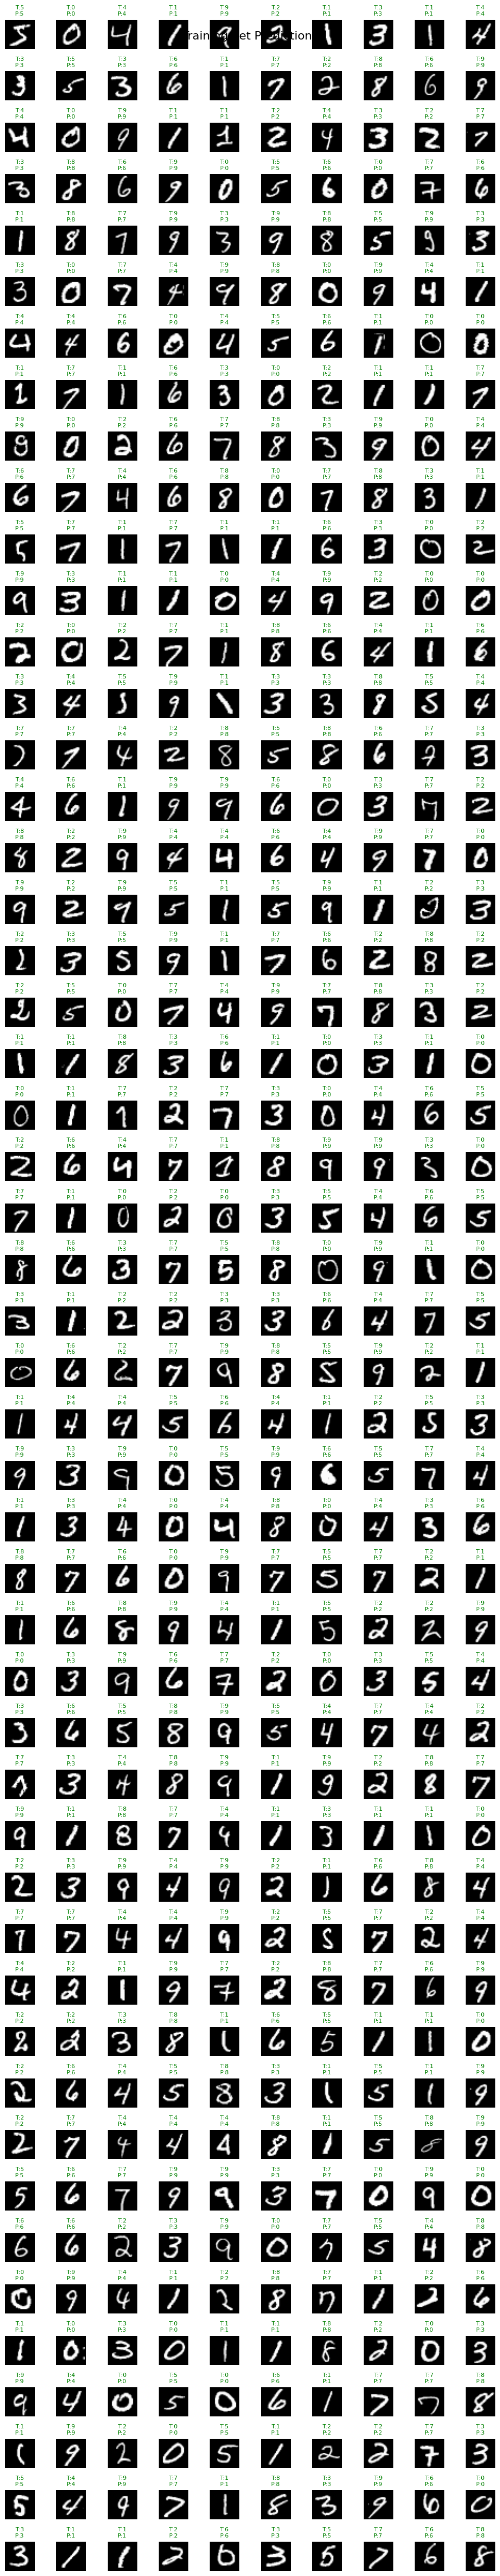

In [7]:

# Generate predictions on the training set
logits_train = state.apply_fn(state.params, x_train)
y_train_pred = jnp.argmax(logits_train, axis=-1)


# Convert to numpy arrays for plotting.
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
y_train_pred_np = np.array(y_train_pred)


# Plot some training examples.
plot_examples(x_train_np, y_train_np, y_train_pred_np, title="Training Set Predictions", n_cols=10)


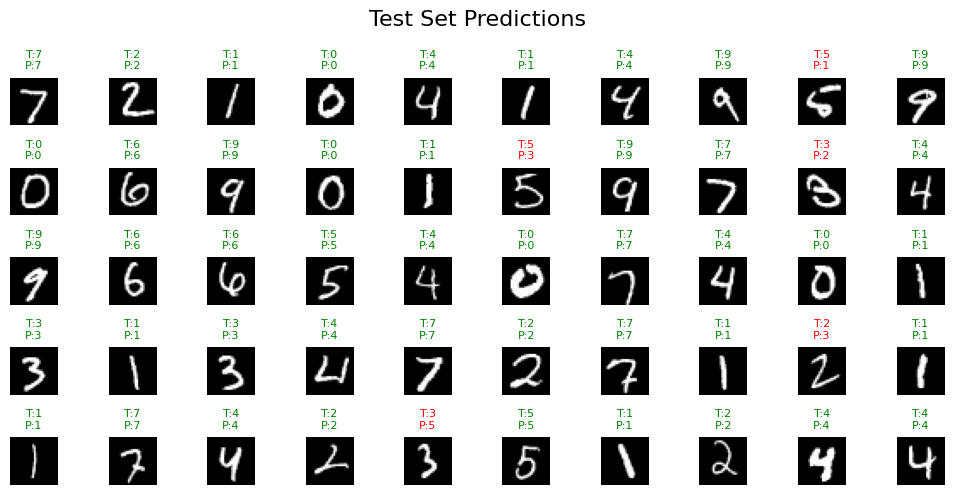

In [8]:
# Generate predictions on the test set
logits_test = state.apply_fn(state.params, x_test)
y_test_pred = jnp.argmax(logits_test, axis=-1)


x_test_np = np.array(x_test)
y_test_np = np.array(y_test)
y_test_pred_np = np.array(y_test_pred)

# Plot some test examples.
plot_examples(x_test_np, y_test_np, y_test_pred_np, title="Test Set Predictions", n_cols=10)

## Influence Function Utilities

We now define the core functions for computing and using influence:

1. **Total loss** helper: merges `(x_data, y_data)` into a function that returns the loss.  
2. **Hessian-vector product**: uses `jax.jvp` trick to compute  $H \cdot v$ .  
3. **Conjugate Gradient** (or a simpler approach) to solve for  $H^{-1} \cdot v$.  
4. **`compute_influences_cg`**: the main function for computing the influence of each training example 
   in a subset on a single test example.



In [9]:
def make_total_loss(loss_fn, apply_fn, x_data, y_data, unravel_fn):
    """
    Returns a function that computes the loss given flattened parameters.
    """
    def total_loss(flat_params):
        params = unravel_fn(flat_params)
        return loss_fn(params, apply_fn, x_data, y_data)
    return total_loss

def compute_single_influence(loss_fn, apply_fn, params, x_i, y_i, unravel_fn, inv_hvp):
    """
    Computes the influence of one training example.
    """
    grad_train = jax.grad(lambda p: loss_fn(p, apply_fn, x_i, y_i))(params)
    flat_grad_train, _ = ravel_pytree(grad_train)
    # Influence is defined as - (grad_train · inv_hvp)
    return -jnp.dot(flat_grad_train, inv_hvp)


def compute_hvp(total_loss, flat_params, v):
    """
    Computes the Hessian-vector product: H v,
    where H = ∇²(total_loss) at flat_params.
    """
    # Note: total_loss should be the *same* function each call, i.e. no random sampling
    return jax.jvp(jax.grad(total_loss), (flat_params,), (v,))[1]


def cg_solve_fori(hvp_fn, b, max_iter=100, tol=1e-5):
    """
    Conjugate gradient solver to solve hvp_fn(x) = b for x.
    Runs for fixed number of iterations using fori_loop.
    
    hvp_fn: function that computes H v given v.
    b: right-hand side vector.
    max_iter: fixed number of iterations to run
    tol: optional tolerance (not explicitly used here, but you can check residual)
    """
    
    x = jnp.zeros_like(b)
    r = b - hvp_fn(x)
    p = r
    rsold = jnp.dot(r, r)
    
    def body_fn(i, state):
        x, r, p, rsold = state
        Ap = hvp_fn(p)
        alpha = rsold / jnp.dot(p, Ap)
        x_new = x + alpha * p
        r_new = r - alpha * Ap
        rsnew = jnp.dot(r_new, r_new)
        p_new = r_new + (rsnew / rsold) * p
        return (x_new, r_new, p_new, rsnew)
    
    init_state = (x, r, p, rsold)
    x, r, p, rsold = jax.lax.fori_loop(0, max_iter, body_fn, init_state)
    return x

def compute_influences_cg(state, 
                          x_train_subset, 
                          y_train_subset, 
                          x_test, 
                          y_test,
                          loss_fn,
                          max_iter=100):
    """
    Computes influence of each training example in x_train_subset on (x_test, y_test)
    using a single Hessian-vector inverse (CG) solve.
    """
    # 1) Flatten current model parameters
    flat_params, unravel_fn = ravel_pytree(state.params)
    
    # 2) Build total loss function for the training subset
    total_loss = make_total_loss(loss_fn, state.apply_fn, x_train_subset, y_train_subset, unravel_fn)
    
    # 3) Define Hessian-vector product (HVP) function for the training subset
    hvp_fn = lambda v: compute_hvp(total_loss, flat_params, v)
    
    # 4) Compute gradient with respect to the test example
    grad_test = jax.grad(lambda p: loss_fn(p, state.apply_fn, x_test, y_test))(state.params)
    flat_grad_test, _ = ravel_pytree(grad_test)
    
    # 5) Conjugate-Gradient solve: v = H⁻¹ * grad_test
    inv_hvp = cg_solve_fori(hvp_fn, flat_grad_test, max_iter=max_iter)
    
    # 6) Compute influence for each training example
    influences = jnp.array([
        compute_single_influence(loss_fn, state.apply_fn, state.params, 
                                 x_train_subset[i:i+1], y_train_subset[i:i+1],
                                 unravel_fn, inv_hvp)
        for i in range(x_train_subset.shape[0])
    ])
    
    return influences



# Example usage:
# ------------------------------------------------
# Suppose you want to measure influences of
# x_train_subset[:100] on a single test example x_test_sample.
x_train_subset = x_train[:100]
y_train_subset = y_train[:100]

index = 11
x_test_sample = x_test[index:index+1]
y_test_sample = y_test[index:index+1]
print("\nTest example label:", y_test_sample)

# Compute influences
influences = compute_influences_cg(state, 
                                   x_train_subset, 
                                   y_train_subset, 
                                   x_test_sample, 
                                   y_test_sample,
                                   loss_fn,
                                   max_iter=100)

# Sort and print
influences_np = np.array(influences)
sorted_indices = np.argsort(np.abs(influences_np))[::-1]

print("\nTop influential training examples:")
for rank, idx in enumerate(sorted_indices):
    print(f"Rank {rank+1} -> training sample {idx}, Influence = {influences_np[idx]:.6f}")






Test example label: [6]

Top influential training examples:
Rank 1 -> training sample 64, Influence = 28.897011
Rank 2 -> training sample 29, Influence = -25.079016
Rank 3 -> training sample 39, Influence = 23.532946
Rank 4 -> training sample 25, Influence = -23.011110
Rank 5 -> training sample 46, Influence = -19.483273
Rank 6 -> training sample 63, Influence = -17.791100
Rank 7 -> training sample 17, Influence = -15.943128
Rank 8 -> training sample 38, Influence = -15.294792
Rank 9 -> training sample 16, Influence = -14.452805
Rank 10 -> training sample 65, Influence = -14.359924
Rank 11 -> training sample 31, Influence = -14.019304
Rank 12 -> training sample 80, Influence = 13.629774
Rank 13 -> training sample 78, Influence = -12.517439
Rank 14 -> training sample 15, Influence = -12.037663
Rank 15 -> training sample 34, Influence = -12.006423
Rank 16 -> training sample 48, Influence = 11.455609
Rank 17 -> training sample 33, Influence = -11.292725
Rank 18 -> training sample 87, Inf

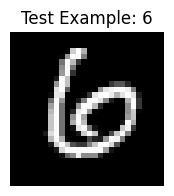

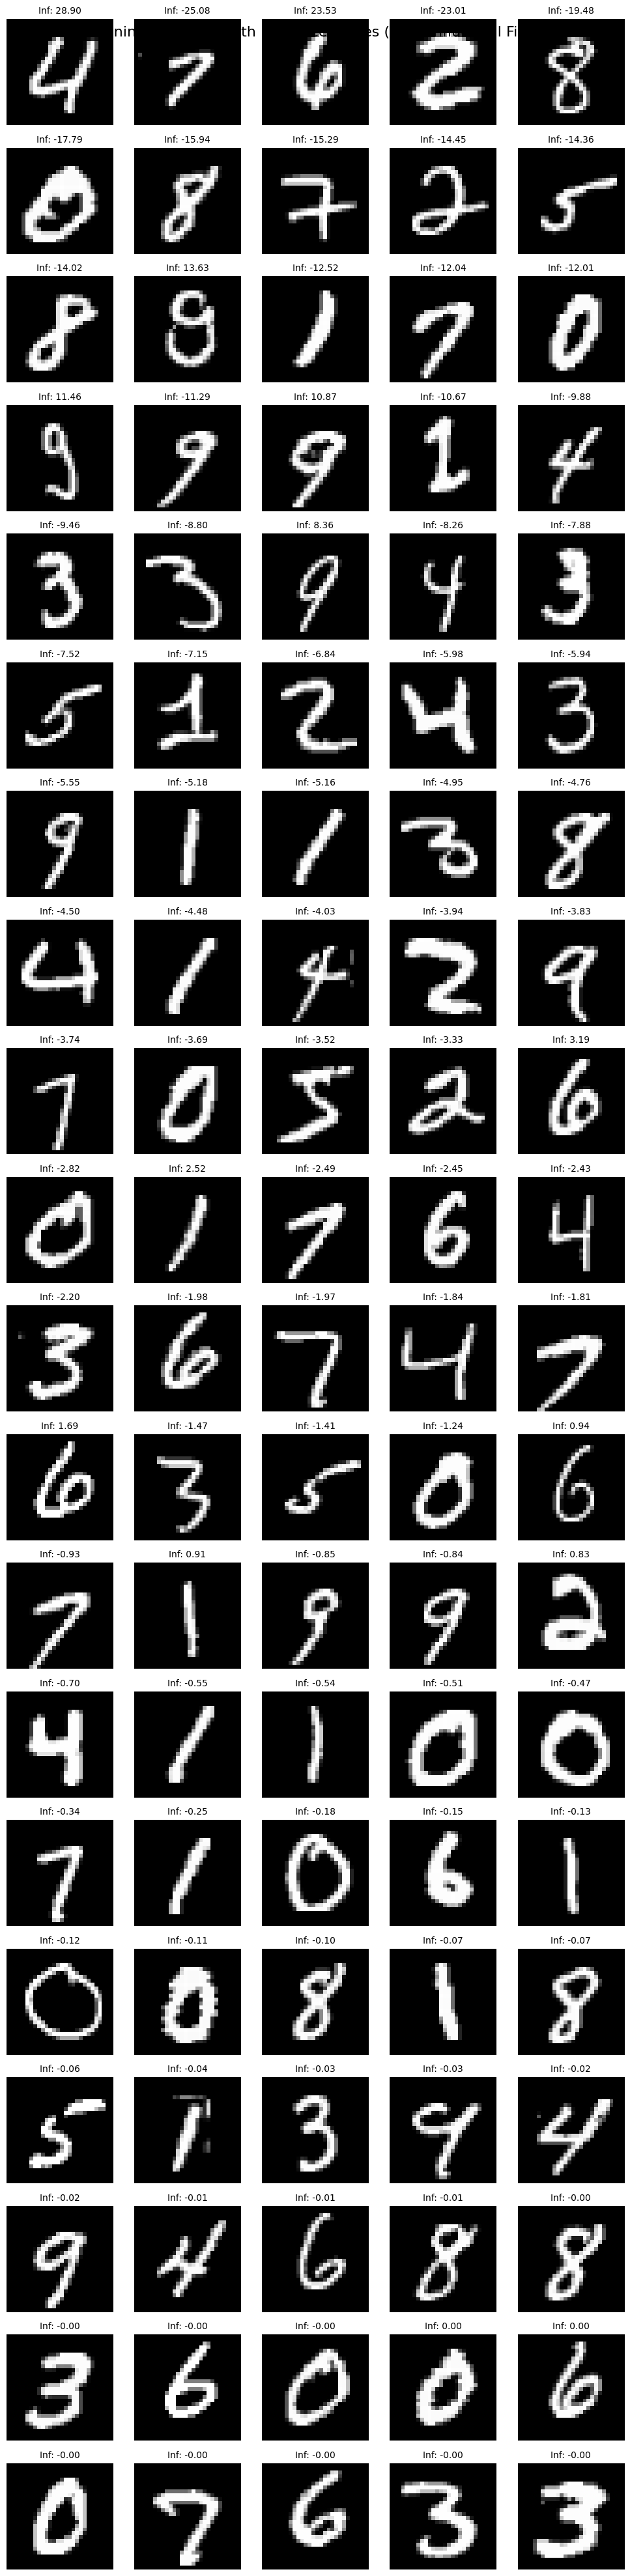

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_influential_examples(x_train_subset, influences, sorted_indices, n_cols=5):
    """
    Plots the training images (from the subset) sorted by influence (most influential first)
    in a grid layout. Influence values are displayed above each image.
    
    Parameters:
      - x_train_subset: NumPy array of training images (shape: [n_examples, 784])
      - influences: NumPy array of influence values (shape: [n_examples])
      - sorted_indices: Array of indices that sorts the influences by absolute value (descending)
      - n_cols: Number of columns in the grid (default 5)
    """
    # Reorder the training examples and influences according to sorted_indices.
    sorted_x = x_train_subset[sorted_indices]
    sorted_inf = influences[sorted_indices]
    
    n = sorted_x.shape[0]
    n_rows = (n + n_cols - 1) // n_cols  # Compute number of rows needed.
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))
    fig.suptitle("Training Examples with Influence Values (Most Influential First)", fontsize=16)
    
    # Flatten axs for easy iteration in case of multiple rows.
    axs = axs.flatten() if n > 1 else [axs]
    
    for i in range(n):
        ax = axs[i]
        # Reshape the flattened image to 28x28.
        image = sorted_x[i].reshape(28, 28)
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        ax.set_title(f"Inf: {sorted_inf[i]:.2f}", fontsize=10)
    
    # Hide any extra subplots.
    for j in range(n, len(axs)):
        axs[j].axis("off")
    
    plt.tight_layout()
    plt.show()

def plot_test_example(x_test_sample, y_test_sample):
    """Displays the test example."""
    image = np.array(x_test_sample[0]).reshape(28, 28)
    plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap="gray")
    plt.title(f"Test Example: {int(y_test_sample[0])}")
    plt.axis("off")
    plt.show()

# First, plot the test example.
plot_test_example(x_test_sample, y_test_sample)

# Then, plot the training examples sorted by influence.
# (Make sure x_train_subset and influences are numpy arrays.)
sorted_indices = np.argsort(np.abs(np.array(influences)))[::-1]
plot_influential_examples(np.array(x_train_subset), np.array(influences), sorted_indices, n_cols=5)


0

Optimizing synthetic training example...


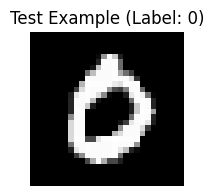

Step 0: Influence = 5810129.0000


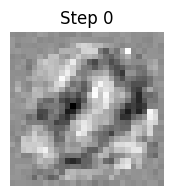

Step 10: Influence = 7033.8867


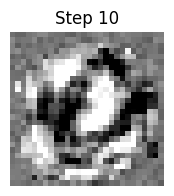

Step 20: Influence = 2194707.5000


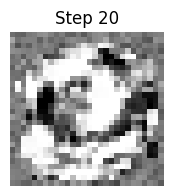

Step 30: Influence = -9285468.0000


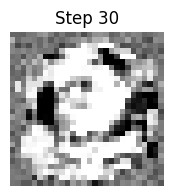

Step 40: Influence = 13916.0469


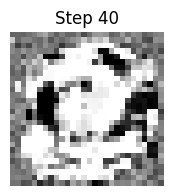

Step 50: Influence = 61710.6250


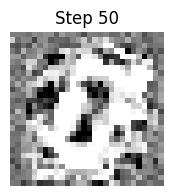

Step 60: Influence = 58.4747


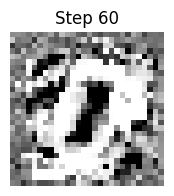

Step 70: Influence = nan


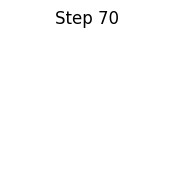

Step 80: Influence = nan


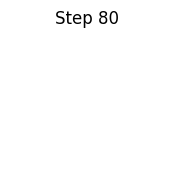

Step 90: Influence = nan


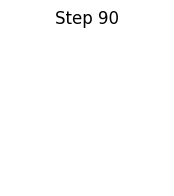

Final influence: nan


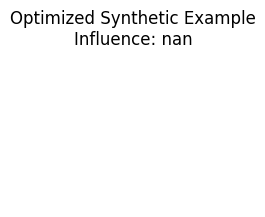

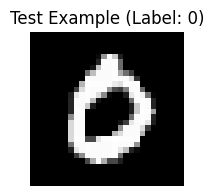

In [11]:
# --- Visualization ---
# Plot the original candidate and the optimized synthetic training example, along with the test example.
def plot_image(x, title):
    plt.figure(figsize=(2,2))
    plt.imshow(np.array(x).reshape(28,28), cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()


def optimize_synthetic_example_adv(state, y_syn, x_init, 
                                   
                                   x_test, y_test,
                                   lr=0.01, num_steps=100, momentum=0.9):
    """
    Uses an adversarial-attack–style update with momentum to optimize a candidate training example x (starting from x_init)
    so that its influence on the given test example is maximized in a beneficial (negative) direction.
    """
    # Flatten model parameters and define total_loss on the training subset.
    flat_params, unravel_fn = ravel_pytree(state.params)


    total_loss = make_total_loss(loss_fn, state.apply_fn, x_train, y_train, unravel_fn)

    
    def hvp_fn(v):
        return compute_hvp(total_loss, flat_params, v)
    
    # Compute the gradient for the test example.
    grad_test = jax.grad(lambda params: loss_fn(params, state.apply_fn, x_test, y_test))(state.params)
    flat_grad_test, _ = ravel_pytree(grad_test)
    
    # Define candidate influence as a function of x_candidate.
    def influence_candidate(x):
        x = jnp.reshape(x, (1, -1))
        grad_train = jax.grad(lambda params: loss_fn(params, state.apply_fn, x, y_syn))(state.params)
        flat_grad_train, _ = ravel_pytree(grad_train)
        hvp_inv_grad_train = cg_solve_fori(hvp_fn, flat_grad_train, max_iter=100)
        return -jnp.dot(flat_grad_test, hvp_inv_grad_train)
    
    # Initialize candidate and velocity.
    x_candidate = x_init
    v = jnp.zeros_like(x_candidate)
  
    
    for i in range(num_steps):
        inf_val, grad_x = jax.value_and_grad(influence_candidate)(x_candidate)

        # Normalize the gradient.
        grad_norm = jnp.linalg.norm(grad_x) + 1e-8
        normalized_grad = grad_x / grad_norm
        
        # Update the velocity with momentum.
        v = momentum * v + normalized_grad
        
        # Adversarial update with momentum.
        x_candidate = x_candidate - lr * v
        
        # Project back to [0,1].
        x_candidate = jnp.clip(x_candidate, 0.0, 1.0)
        
        if i % 10 == 0:
            print(f"Step {i}: Influence = {inf_val:.4f}")
            plot_image(x_candidate, f"Step {i}")
    
    return x_candidate, influence_candidate(x_candidate)

# Flatten the parameters.
flat_params, unravel_fn = ravel_pytree(state.params)

# Compute gradient for the test example.
index = 3
x_test_sample = x_test[index:index+1]
y_test_sample = y_test[index:index+1]

grad_test = jax.grad(lambda params: loss_fn(params, state.apply_fn, x_test_sample, y_test_sample))(state.params)
flat_grad_test, _ = ravel_pytree(grad_test)


# --- Synthetic Example Optimization ---
# We choose a candidate initialization. For example, we can start from the average image
# of all training examples with the same label as the test sample.
test_label = y_test_sample[0]

print(test_label)
matching = (y_train == test_label)
if matching.sum() > 0:
    x_init = jnp.mean(x_train[matching], axis=0, keepdims=True)
else:
    x_init = jnp.mean(x_train, axis=0, keepdims=True)

# key = jax.random.PRNGKey(42)
# x_init = jax.random.uniform(key, shape=(1, 784), minval=0.0, maxval=1.0)


x_init = jax.random.uniform(key, shape=(1, 784), minval=0.5, maxval=0.5)


# Optimize the candidate training example.
print("\nOptimizing synthetic training example...")
plot_image(x_test_sample, f"Test Example (Label: {int(y_test_sample[0])})")
x_synth, final_influence = optimize_synthetic_example_adv(state, test_label, x_init, 
                                                               x_test_sample, y_test_sample,
                                                               lr=0.5, num_steps=100)
print(f"Final influence: {final_influence:.4f}")
    



plot_image(x_synth, f"Optimized Synthetic Example\nInfluence: {final_influence:.2f}")
plot_image(x_test_sample, f"Test Example (Label: {int(y_test_sample[0])})")
